In [1]:
import numpy as np
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
import torch.nn as nn
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [3]:
import torch.nn as nn

class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


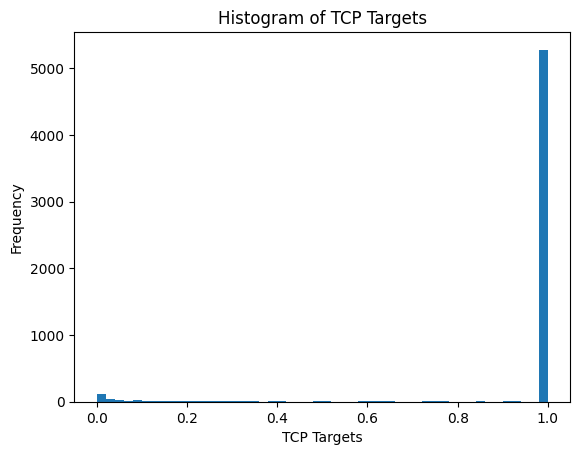

In [4]:
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
embeddings = data['test_embeddings']
probs = data['probs']
y_true = data['y_train']
y_hat = np.argmax(probs, axis=1)
p_y_hat = np.max(probs, axis=1)
y_true_class = np.argmax(data['y_train'], axis=1) 
p_y_star = np.sum(probs * y_true, axis=1)
#tcp targets
tcp_targets= p_y_star/ p_y_hat

plt.hist(tcp_targets, bins=50)
plt.xlabel('TCP Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Targets')
plt.show()



In [8]:
X= embeddings
y = tcp_targets

from sklearn.model_selection import train_test_split
import numpy as np

# correctness labels: 1 for correct, 0 for incorrect
is_correct_full = (y_hat == y_true_class).astype(int)

# stratified split to keep same success/error ratio
train_indices, test_indices = train_test_split(
    np.arange(len(embeddings)),
    test_size=0.2,
    random_state=42,
    stratify=is_correct_full
)

# check counts
train_success = np.sum(is_correct_full[train_indices] == 1)
train_error   = np.sum(is_correct_full[train_indices] == 0)
test_success  = np.sum(is_correct_full[test_indices] == 1)
test_error    = np.sum(is_correct_full[test_indices] == 0)

print(f"Train: {train_success} successes, {train_error} errors")
print(f"Test:  {test_success} successes, {test_error} errors")


Train: 4220 successes, 341 errors
Test:  1056 successes, 85 errors


In [9]:
# Use the split indices
X_train = embeddings[train_indices]
y_train = tcp_targets[train_indices]
y_hat_train = y_hat[train_indices]
y_true_class_train = y_true_class[train_indices]

X_test = embeddings[test_indices]
y_test = tcp_targets[test_indices]
y_hat_test = y_hat[test_indices]
y_true_class_test = y_true_class[test_indices]



Errors in train: 341, Successes in train: 4220
Number of success batches: 65, Number of error batches: 5
Epoch 1/100 | success_chunk=0/64 | error_chunk=0/4
Epoch 1/100 | success_chunk=1/64 | error_chunk=1/4
Epoch 1/100 | success_chunk=2/64 | error_chunk=2/4
Epoch 1/100 | success_chunk=3/64 | error_chunk=3/4
Epoch 1/100 | success_chunk=4/64 | error_chunk=4/4
Epoch 1/100 | success_chunk=5/64 | error_chunk=0/4
Epoch 1/100 | success_chunk=6/64 | error_chunk=1/4
Epoch 1/100 | success_chunk=7/64 | error_chunk=2/4
Epoch 1/100 | success_chunk=8/64 | error_chunk=3/4
Epoch 1/100 | success_chunk=9/64 | error_chunk=4/4
Epoch 1/100 | success_chunk=10/64 | error_chunk=0/4
Epoch 1/100 | success_chunk=11/64 | error_chunk=1/4
Epoch 1/100 | success_chunk=12/64 | error_chunk=2/4
Epoch 1/100 | success_chunk=13/64 | error_chunk=3/4
Epoch 1/100 | success_chunk=14/64 | error_chunk=4/4
Epoch 1/100 | success_chunk=15/64 | error_chunk=0/4
Epoch 1/100 | success_chunk=16/64 | error_chunk=1/4
Epoch 1/100 | success

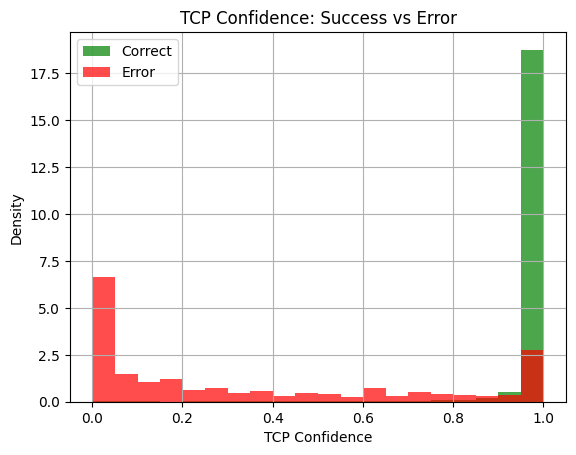

In [ ]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Determine which are errors/successes on the training split
is_correct_train = (y_hat_train == y_true_class_train)
X_train_errors = X_train_tensor[~is_correct_train]
y_train_errors = y_train_tensor[~is_correct_train]

X_train_success = X_train_tensor[is_correct_train]
y_train_success = y_train_tensor[is_correct_train]
print(f"Errors in train: {len(X_train_errors)}, Successes in train: {len(X_train_success)}")

X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

error_batch_size = 64
success_batch_size = 64
num_epochs = 100
num_success_batches = len(X_train_success) // success_batch_size
num_error_batches = len(X_train_errors) // error_batch_size

print(f"Number of success batches: {num_success_batches}, Number of error batches: {num_error_batches}")

input_dim = X_train.shape[1]
output_dim = 1
model = ConfidenceNet(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()



# Training the model
for epoch in range(num_epochs):
    model.train()
    train_losses=[]
    #shuffle the success and errors
    perm_success= torch.randperm(len(X_train_success))
    perm_errors = torch.randperm(len(X_train_errors))

    X_success_shuffled = X_train_success[perm_success]
    y_success_shuffled = y_train_success[perm_success]
    X_errors_shuffled = X_train_errors[perm_errors]
    y_errors_shuffled = y_train_errors[perm_errors]

    #split into chunks

    success_chunks_X = X_success_shuffled.split(success_batch_size)
    success_chunks_y = y_success_shuffled.split(success_batch_size)
    error_chunks_X = list(X_errors_shuffled.split(error_batch_size))
    error_chunks_y = list(y_errors_shuffled.split(error_batch_size))


    # Iterate over success batches
    for i in range (num_success_batches):
        err_idx= i% num_error_batches

        print(
            f"Epoch {epoch+1}/{num_epochs} | success_chunk={i}/{num_success_batches-1} "
            f"| error_chunk={err_idx}/{num_error_batches-1}"
        )
        
        X_batch = torch.cat([
            success_chunks_X[i],
            error_chunks_X[err_idx]
        ])
        y_batch = torch.cat([
            success_chunks_y[i],
            error_chunks_y[err_idx]
        ])
        perm = torch.randperm(X_batch.size(0))
        X_batch = X_batch[perm]
        y_batch = y_batch[perm]
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f}")

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch {epoch+1:02d} | Validation Loss: {avg_val_loss:.6f}")
    







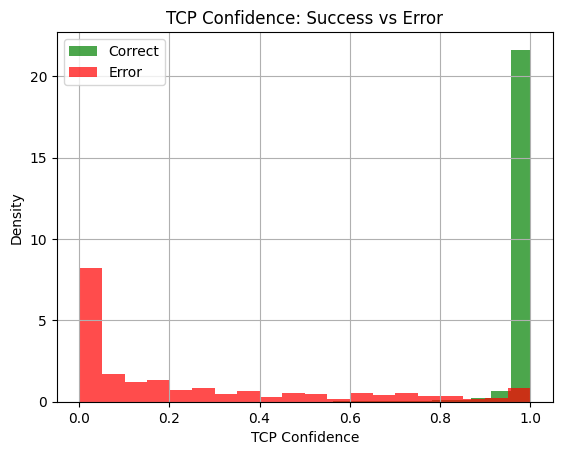

In [11]:
model.eval()
with torch.no_grad():
    Xall_tensor = torch.tensor(X_train, dtype=torch.float32)
    confidence_scores_tcp = model(Xall_tensor).cpu().numpy() 

is_correct_full = (y_hat_train == y_true_class_train)
success_conf = confidence_scores_tcp[is_correct_full]
error_conf = confidence_scores_tcp[~is_correct_full]

plt.hist(success_conf, bins=20, density=True, alpha=0.7, label='Correct', color='green')
plt.hist(error_conf, bins=20, density=True, alpha=0.7, label='Error', color='red')
plt.xlabel('TCP Confidence')
plt.ylabel('Density')
plt.title('TCP Confidence: Success vs Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def default_ECE(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += prop_in_bin* np.abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece
ece_tcp= default_ECE(confidence_scores_tcp, y_hat, y_true_class, n_bins=15)
print(f"ECE for TCP confidence scores: {ece_tcp:.4f}")

correct_labels = is_correct_full.astype(int)

# Get calibration curve values
prob_true, prob_pred = calibration_curve(correct_labels, confidence_scores_tcp, n_bins=15, strategy='uniform')

# Plot reliability diagram
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='TCP Reliability')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.title('Reliability Curve (TCP)')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()